<a href="https://colab.research.google.com/github/googlecolab/colabtools/blob/master/notebooks/colab-github-demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression 
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.ensemble import RandomForestClassifier

In [76]:
# Use a subset of the character-predictions data set focused on major houses
url = 'https://storage.googleapis.com/storytelling-megano/raw-data/character-predictions-9.csv'
df = pd.read_csv(url, sep=',')

In [115]:
((df['alive'] >= .5) == df['isAlive']).mean()
# Get rid of previous prediction info
df.drop(['actual','pred','alive','plod'],axis=1,inplace=True)
df.head()

,S.No,male,house,book1,book2,book3,book4,book5,isMarried,isNoble,numDeadRelations,boolDeadRelations,isPopular,popularity,isAlive
0,4,0,House Arryn,0,0,0,0,0,1,1,0,0,0,0.183946,0
1,309,0,House Arryn,0,0,0,1,0,1,0,1,1,0,0.080268,1
2,313,0,House Arryn,1,0,0,0,0,0,0,0,0,0,0.006689,1
3,341,1,House Arryn,1,0,0,0,0,0,0,0,0,0,0.003344,1
4,548,1,House Arryn,0,0,0,1,1,0,0,0,0,0,0.016722,1


In [78]:
def get_house(value):
    value = value.lower()
    v = [k for (k, v) in house.items() if value in v]
    return v[0] if len(v) > 0 else value.title()

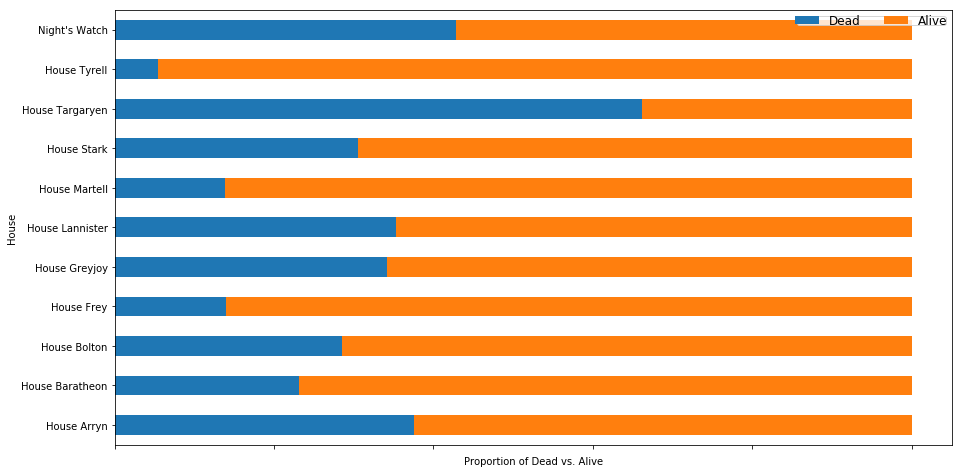

In [79]:
# Q: Which house has the highest proportion of deaths?
# A: Targaryens. 
data = df.groupby(["house", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 8), width = .5)
_ = p.set_xticklabels(""), p.legend(["Dead", "Alive"], fontsize = 12., loc = "upper right", ncol = 2, borderpad = -.15)
_ = p.set_ylabel("House"), p.set_xlabel("Proportion of Dead vs. Alive")

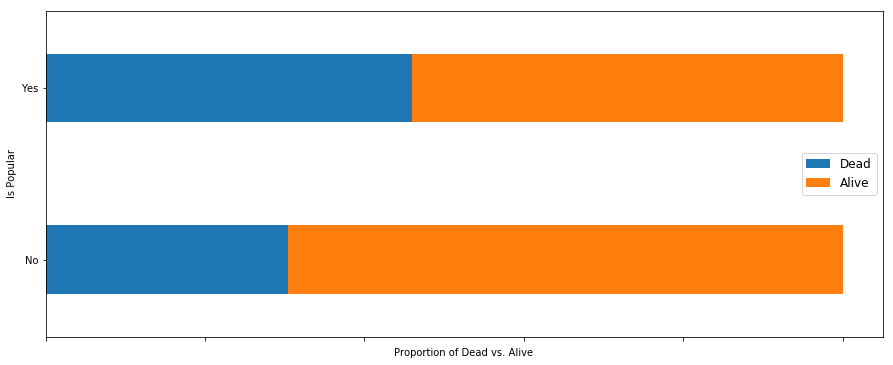

In [80]:
# Q: Is there a relationship between survival and popularity? 
# A: A higher proportion of popular characters die
data = df.groupby(["isPopular", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 6), width = .4)
_ = p.set_yticklabels(["No", "Yes"]), p.set_xticklabels(""), p.legend(["Dead", "Alive"], fontsize = 12.)
_ = p.set_ylabel("Is Popular"), p.set_xlabel("Proportion of Dead vs. Alive")

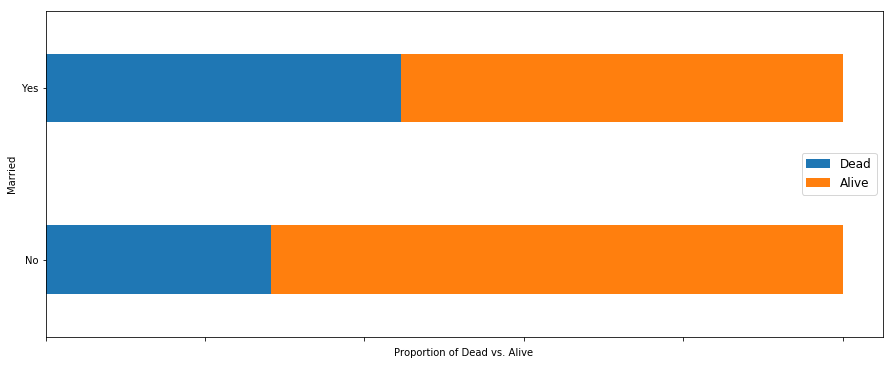

In [81]:
# Q: Is there a relationship between survial and marriage? 
# A: More of the dead characters were married than single.  
data = df.groupby(["isMarried", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 6), width = .4)
_ = p.set_yticklabels(["No", "Yes"]), p.set_xticklabels(""), p.legend(["Dead", "Alive"], fontsize = 12.)
_ = p.set_ylabel("Married"), p.set_xlabel("Proportion of Dead vs. Alive")

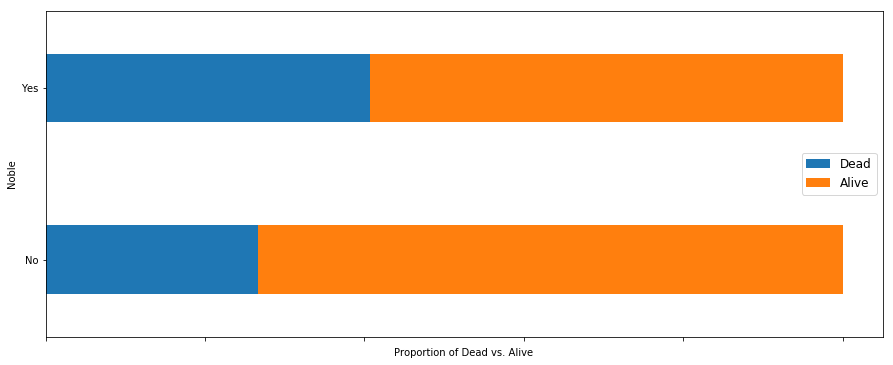

In [82]:
# Q: Is there a relationship between survial and being noble? 
# A: More of the dead characters were noble.  
data = df.groupby(["isNoble", "isAlive"]).count()["S.No"].unstack().copy(deep = True)
p = data.div(data.sum(axis = 1), axis = 0).plot.barh(stacked = True, rot = 0, figsize = (15, 6), width = .4)
_ = p.set_yticklabels(["No", "Yes"]), p.set_xticklabels(""), p.legend(["Dead", "Alive"], fontsize = 12.)
_ = p.set_ylabel("Noble"), p.set_xlabel("Proportion of Dead vs. Alive")

In [83]:
### Logistic Regression

# character data
url = 'https://storage.googleapis.com/storytelling-megano/raw-data/character-predictions-9.csv'
train = pd.read_csv(url)

In [84]:
# before splitting, just predict the mean of the entire dataset
na_rate = train['isAlive'].sum()/float(train.shape[0]) # null accuracy
print 'null accuracy rate: %s' %na_rate

null accuracy rate: 0.6817359855334539


In [85]:
# Turn house categorical variable into numeric
df_house = pd.get_dummies(df['house'])

# Join the dummy variables to the main dataframe
df_new = pd.concat([df, df_house], axis=1)
df_new = df_new.drop('house', axis=1)

In [86]:
# define X and y
feature_cols = ['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried', 'isNoble', 'numDeadRelations', 'popularity']
X = df_new[feature_cols]
y = df_new.isAlive.values

In [87]:
df_new.head()

,S.No,male,book1,book2,book3,book4,book5,isMarried,isNoble,numDeadRelations,...,House Baratheon,House Bolton,House Frey,House Greyjoy,House Lannister,House Martell,House Stark,House Targaryen,House Tyrell,Night's Watch
0,4,0,0,0,0,0,0,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1,309,0,0,0,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,313,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,341,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,548,1,0,0,0,1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
lg = LogisticRegression()
print(cross_val_score(lg, X, y, cv=10, scoring='accuracy').mean())

ln = LinearRegression()
print(np.sqrt(abs(cross_val_score(ln, X, y, cv=10, scoring='neg_mean_squared_error').mean())))

0.6814935064935066
0.4499127348001184


In [89]:
logreg = LogisticRegression()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
logreg.fit(X_train,y_train)
preds = logreg.predict(X_test)
probs = logreg.predict_proba(X_test)[:, 1]
# SCORE(logreg)

In [90]:
nb = MultinomialNB()
print cross_val_score(nb, X, y, cv=10).mean()

0.7050012025012025


In [91]:
nb = MultinomialNB()
nb.fit(X_train, y_train)
preds = nb.predict(X_test)
probs = nb.predict_proba(X_test)[:, 1]
# SCORE(nb)

In [93]:
# Try splitting the data more times
lg = LogisticRegression()
logval = cross_val_score(lg, X, y, cv=100).mean()
print logval

nb = MultinomialNB()
nbval = cross_val_score(nb, X, y, cv=100).mean()
print nbval

ln = LinearRegression()
lrval = np.sqrt(abs(cross_val_score(ln, X, y, cv=100, scoring='neg_mean_squared_error').mean()))
print lrval

0.6926666666666667
0.7084999999999999
0.43881357278798966


In [94]:
# Decision tree
train = df_new

In [95]:
# before splitting anything, just predict the mean of the entire dataset
train['prediction'] = train.isAlive.mean()

In [96]:
# calculate RMSE for those predictions
np.sqrt(metrics.mean_squared_error(train.isAlive, train.prediction))

0.46580256714855517

In [97]:
train.shape

(553, 26)

In [98]:
# define X and y
feature_cols = ['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried', 'isNoble', 'numDeadRelations', 'popularity']
X = df_new[feature_cols]
y = df_new.isAlive.values

In [99]:
# instantiate a DecisionTreeClassifier
treereg = DecisionTreeClassifier(max_depth=10, random_state=1)
treereg

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=10,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=1,
            splitter='best')

In [102]:
# use leave-one-out cross-validation (LOOCV) to estimate the RMSE for this model
scores = cross_val_score(treereg, X, y, cv=14, scoring='accuracy')
np.mean(scores)

0.7195753807595912

In [103]:
# try different tree depths
max_depth_range = range(1,15)

# store the average RMSE for each max_depth
RMSE_scores = []

# LOOCV with each max_depth
for depth in max_depth_range:
    treereg = DecisionTreeClassifier(max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='accuracy')
    RMSE_scores.append(np.mean(MSE_scores))
print len(MSE_scores)

14


Text(0,0.5,'accuracy (higher is better)')

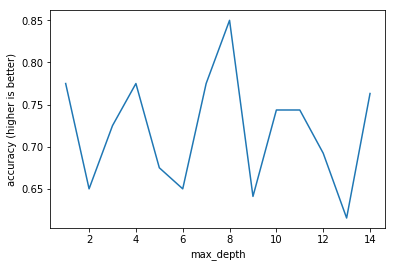

In [104]:
# plot max_depth (x-axis) vs MSE (y-axis)
plt.plot(max_depth_range, MSE_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy (higher is better)')

Text(0,0.5,'accuracy (higher is better)')

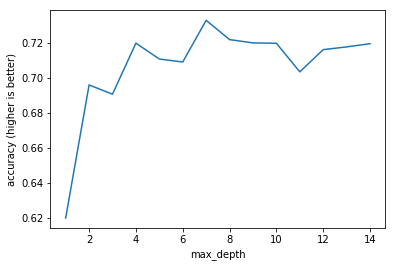

In [105]:
# try different tree depths
max_depth_range = range(1,15)

# store the average RMSE for each max_depth
RMSE_scores = []

# LOOCV with each max_depth
for depth in max_depth_range:
    treereg = DecisionTreeClassifier(criterion='gini', max_features=10, max_depth=depth, random_state=1)
    MSE_scores = cross_val_score(treereg, X, y, cv=14, scoring='accuracy')
    RMSE_scores.append(np.mean(MSE_scores))

# plot max_depth (x-axis) vs RMSE (y-axis)
plt.plot(max_depth_range, RMSE_scores)
plt.xlabel('max_depth')
plt.ylabel('accuracy (higher is better)')

In [106]:
## ** remember to split the training and test data set ** ##

# instantiate a DecisionTreeClassifier with dept of 12 because that had higheset accuracy
treereg = DecisionTreeClassifier(max_depth=12, random_state=1)
treereg.fit(X, y)
my_prediction = treereg.predict(X)

In [116]:

# use leave-one-out cross-validation (LOOCV) to estimate the MSE for this model
scores = cross_val_score(treereg, X, y, cv=14, scoring='neg_mean_squared_error')
np.mean(np.sqrt(-scores))

0.5286344245978418

In [117]:
# Gini importance of each feature (normalized total reduction of error brought by that feature)
pd.DataFrame({'feature':feature_cols, 'importance':treereg.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
9,popularity,0.433172
4,book4,0.094636
0,male,0.075922
2,book2,0.074095
7,isNoble,0.069164
3,book3,0.065323
6,isMarried,0.057158
8,numDeadRelations,0.056576
5,book5,0.041734
1,book1,0.032220


In [118]:
# create a Graphviz file
export_graphviz(treereg, out_file='tree_GOT.dot', feature_names=feature_cols)

# At the command line, run this to convert to PNG:
#   dot -Tpng tree_GOT.dot -o tree_GOT.png

In [119]:
# Compare original prediction accuracy
url = 'https://storage.googleapis.com/storytelling-megano/raw-data/character-predictions-9.csv'
df = pd.read_csv(url, sep=',')

((df['alive'] >= .5) == df['isAlive']).mean()

0.72875226039783

In [120]:
# random forrest 
rfclf = RandomForestClassifier(n_estimators=100)
# define X and y
feature_cols = ['male', 'book1', 'book2', 'book3', 'book4', 'book5', 'isMarried', 'isNoble', 'numDeadRelations', 'popularity']
X = df_new[feature_cols]
y = df_new.isAlive.values
rfclf = rfclf.fit(X, y)

In [121]:
# Gini importance of each feature (normalized total reduction of error brought by that feature)
pd.DataFrame({'feature':feature_cols, 'importance':rfclf.feature_importances_}).sort_values('importance', ascending=False)

,feature,importance
9,popularity,0.465406
4,book4,0.098796
8,numDeadRelations,0.076818
2,book2,0.067882
7,isNoble,0.057441
3,book3,0.050039
0,male,0.050015
6,isMarried,0.046497
1,book1,0.044846
5,book5,0.042260
